In [3]:
import numpy as np
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = horizon / timesteps
    S = np.zeros((timesteps, n_sims))
    S[0, :] = s0
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)
        S[i, :] = S[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * w)
    return S

def simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract='accumulator', seed=None):
    """
    Simulate the value of an ACDC (Accumulator/Decumulator) contract using Monte Carlo.
    
    For each period, the simulation:
      - Accumulates shares daily based on:
          if delta*(price - B) < 0:
              if delta*(price - K) >= 0: accumulate m shares
              else: accumulate G * m shares
      - At the period's settlement date, calculates the payoff using:
          A_i = delta * (S_settlement - K)
          Payoff_i = (accumulated shares in period) * A_i, discounted to present.
    
    The total payoff is the sum over all periods.
    
    Returns:
        price: float, the estimated price of the ACDC contract.
    """
    n_steps = int(days_per_year * T)  # Total simulation steps; for 1 year, n_steps = 252
    S = simulate_path(S0, r, sigma, T, n_steps, N_paths, seed)
    delta = 1 if contract.lower() == 'accumulator' else -1
    period_indices = np.linspace(0, n_steps, N_periods + 1, dtype=int)
    period_payoffs = np.zeros((N_paths, N_periods))
    
    for i in range(N_periods):
        start_index = period_indices[i]
        # For the final period, use the full period so that t_settlement = n_steps/days_per_year
        if i == N_periods - 1:
            settlement_index = n_steps - 1  # Last index of S (i.e., day 251, which represents 252 days)
            t_settlement = n_steps / days_per_year  # t_settlement = 252/252 = 1 year
            S_settlement = S[settlement_index, :]
        else:
            settlement_index = period_indices[i + 1] - 1
            t_settlement = (settlement_index + 1) / days_per_year  # +1 to count days correctly
            S_settlement = S[settlement_index, :]
        
        X_i = np.zeros(N_paths)
        days_in_period = settlement_index - start_index + 1
        
        for day in range(days_in_period):
            for sim in range(N_paths):
                price = S[start_index + day, sim]
                if delta * (price - B) < 0:
                    if delta * (price - K) >= 0:
                        X_i[sim] += m  
                    else:
                        X_i[sim] += G * m  
                else:
                    X_i[sim] += 0
        
        A_i = delta * (S_settlement - K)
        period_payoff = X_i * A_i
        discount_factor = np.exp(-r * t_settlement)
        period_payoffs[:, i] = period_payoff * discount_factor
        
        # Print discount factor and the average discounted payoff for this period
        avg_payoff = np.mean(period_payoffs[:, i])
        #print(f"Period {i+1}: t_settlement = {t_settlement*days_per_year:.3f} days, discount_factor = {discount_factor:.9f}, avg discounted payoff = {avg_payoff:.4f}")
    
    total_payoffs = np.sum(period_payoffs, axis=1)
    price = np.mean(total_payoffs)
    return price

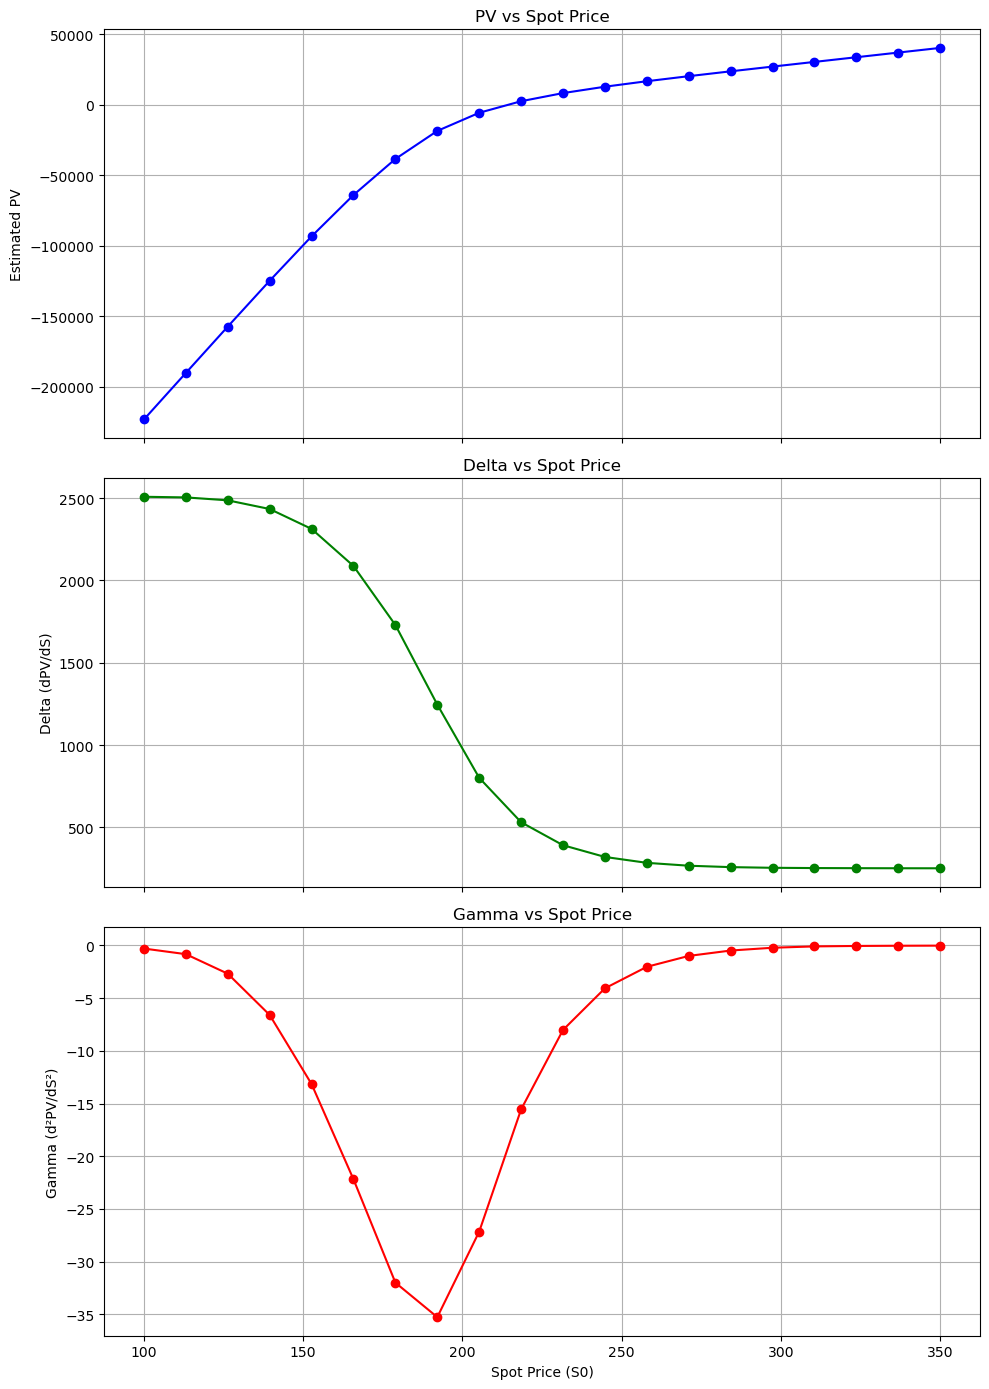

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_delta_gamma_vs_spot(S0_range, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=None):
    """
    Simulate and plot the present value (PV), delta, and gamma of the ACDC contract as a function of the initial spot price.
    
    Parameters:
        S0_range (array-like): Array of initial spot prices.
        r (float): Risk-free rate.
        sigma (float): Volatility.
        T (float): Time to expiry in years.
        N_paths (int): Number of Monte Carlo simulation paths.
        N_periods (int): Number of settlement periods.
        days_per_year (int): Number of trading days per year.
        m (float): Number of shares accumulated per eligible day.
        strike_pct (float): Strike as a percentage of S0.
        barrier_pct (float): Barrier as a percentage of S0.
        G (float): Gearing factor.
        contract_type (str): Either 'accumulator' or 'decumulator'.
        seed (int or None): Seed for reproducibility.
    """
    PVs = []
    for S0 in S0_range:
        # Recalculate strike and barrier based on the current S0
        #K = S0 * (strike_pct / 100.0)
        #B = S0 * (barrier_pct / 100.0)
        price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
        PVs.append(price)
    PVs = np.array(PVs)
    
    # Compute numerical derivatives: delta as first derivative, gamma as second derivative.
    delta = np.gradient(PVs, S0_range)
    gamma = np.gradient(delta, S0_range)

    # Save S0, delta, and gamma in a CSV file.
    data = np.vstack((S0_range, delta, gamma)).T
    np.savetxt("delta_gamma_vs_spot.csv", data, delimiter=",", header="S0,Delta,Gamma", comments="")
    
    # Create a figure with 3 subplots: one for PV, one for delta, and one for gamma.
    fig, axs = plt.subplots(3, 1, figsize=(10, 14), sharex=True)
    
    axs[0].plot(S0_range, PVs, marker='o', linestyle='-', color='b')
    axs[0].set_title('PV vs Spot Price')
    axs[0].set_ylabel('Estimated PV')
    axs[0].grid(True)
    
    axs[1].plot(S0_range, delta, marker='o', linestyle='-', color='g')
    axs[1].set_title('Delta vs Spot Price')
    axs[1].set_ylabel('Delta (dPV/dS)')
    axs[1].grid(True)
    
    axs[2].plot(S0_range, gamma, marker='o', linestyle='-', color='r')
    axs[2].set_title('Gamma vs Spot Price')
    axs[2].set_xlabel('Spot Price (S0)')
    axs[2].set_ylabel('Gamma (d²PV/dS²)')
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    strike_pct = 90
    barrier_pct = 500
    r = 0.0507          # risk-free rate (annualized).
    sigma = 0.2          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 252  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte aCarlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = S0*(strike_pct/100.0)          # strike price.
    #B = 216.062714      # auto-call.
    B = S0*(barrier_pct/100.0)            # knock-out barrier.
    G = 10                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 399 #int or None, seed for reproducibility.
    
    # Define a range of S0 values to explore
    S0_range = np.linspace(100, 350, 20)
    
    # Plot PV, delta, and gamma versus spot
    plot_delta_gamma_vs_spot(S0_range, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=seed)


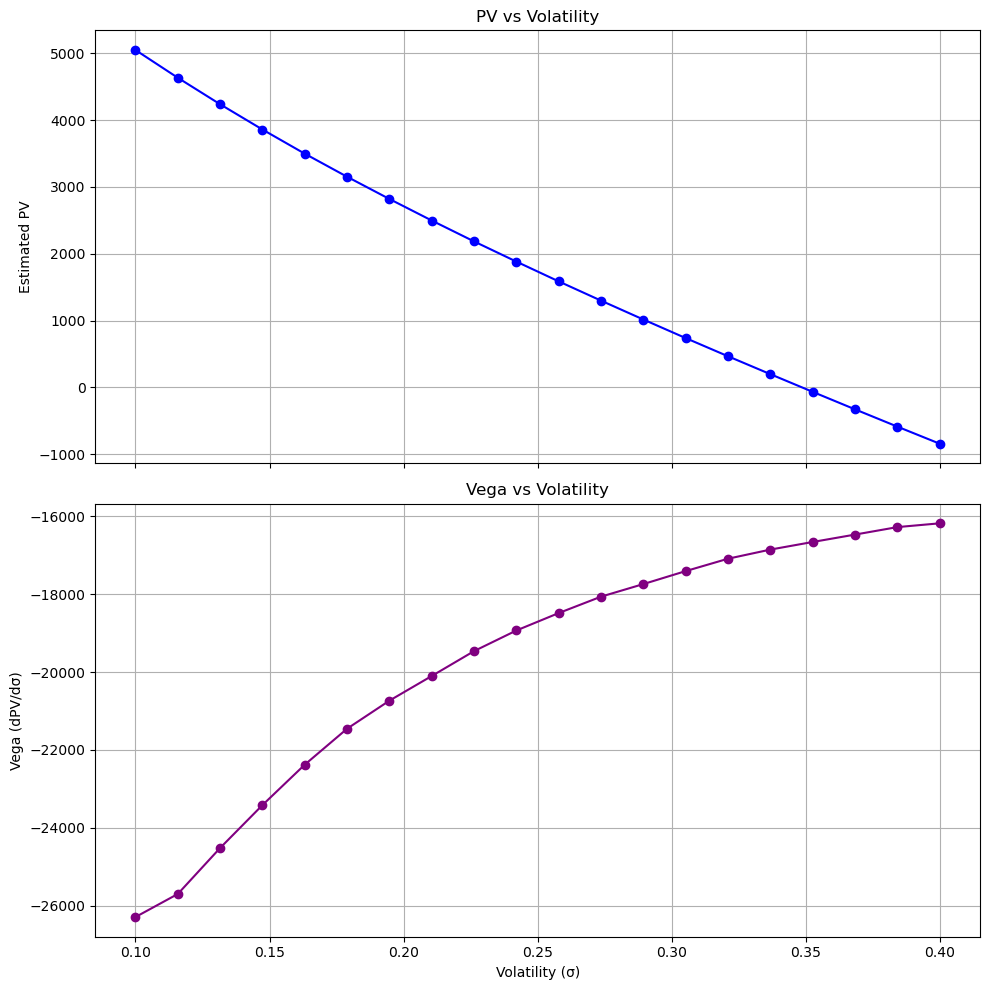

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vega_vs_volatility(S0, r, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, sigma_range, seed=None):
    """
    Simulate and plot the present value (PV) of the ACDC contract as a function of volatility,
    and compute the vega as the first derivative dPV/dσ.
    
    Parameters:
        S0 (float): Initial spot price.
        r (float): Risk-free rate.
        T (float): Time to expiry in years.
        N_paths (int): Number of Monte Carlo simulation paths.
        N_periods (int): Number of settlement periods.
        days_per_year (int): Number of trading days per year.
        m (float): Number of shares accumulated per eligible day.
        strike_pct (float): Strike as a percentage of S0.
        barrier_pct (float): Barrier as a percentage of S0.
        G (float): Gearing factor.
        contract_type (str): Either 'accumulator' or 'decumulator'.
        sigma_range (array-like): Array of volatility values to explore.
        seed (int or None): Seed for reproducibility.
    """
    PVs = []
    for sigma in sigma_range:
        # Recalculate strike and barrier based on the current S0 (remain unchanged as percentage of S0)
        #K = S0 * (strike_pct / 100.0)
        #B = S0 * (barrier_pct / 100.0)
        price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
        PVs.append(price)
    PVs = np.array(PVs)
    
    # Compute numerical derivative with respect to sigma (vega)
    vega = np.gradient(PVs, sigma_range)
    
    # Create a figure with 2 subplots: one for PV vs sigma and one for vega vs sigma.
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    axs[0].plot(sigma_range, PVs, marker='o', linestyle='-', color='b')
    axs[0].set_title('PV vs Volatility')
    axs[0].set_ylabel('Estimated PV')
    axs[0].grid(True)
    
    axs[1].plot(sigma_range, vega, marker='o', linestyle='-', color='purple')
    axs[1].set_title('Vega vs Volatility')
    axs[1].set_xlabel('Volatility (σ)')
    axs[1].set_ylabel('Vega (dPV/dσ)')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    strike_pct = 90
    barrier_pct = 110
    r = 0.053          # risk-free rate (annualized).
    sigma = 0.2          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 264  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte aCarlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = S0*(strike_pct/100.0)          # strike price.
    #B = 216.062714      # auto-call.
    B = S0*(barrier_pct/100.0)            # knock-out barrier.
    G = 1                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 100 #int or None, seed for reproducibility.

    # Define a range of volatility values to explore.
    sigma_range = np.linspace(0.1, 0.4, 20)  # for example, volatilities from 10% to 40%
    
    # Plot PV and vega versus volatility
    plot_vega_vs_volatility(S0, r, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, sigma_range, seed=seed)


In [2]:
import numpy as np

def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = horizon / timesteps
    S = np.zeros((timesteps, n_sims))
    S[0, :] = s0
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)
        S[i, :] = S[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * w)
    return S

def simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract='accumulator', seed=None):
    """
    Simulate the value of an ACDC (Accumulator/Decumulator) contract using Monte Carlo.
    
    Returns:
        price: float, the estimated price of the ACDC contract.
    """
    n_steps = int(days_per_year * T)  # Total simulation steps; for 1 year, n_steps = 252
    S = simulate_path(S0, r, sigma, T, n_steps, N_paths, seed)
    delta = 1 if contract.lower() == 'accumulator' else -1
    period_indices = np.linspace(0, n_steps, N_periods + 1, dtype=int)
    period_payoffs = np.zeros((N_paths, N_periods))
    
    for i in range(N_periods):
        start_index = period_indices[i]
        if i == N_periods - 1:
            settlement_index = n_steps - 1
            t_settlement = n_steps / days_per_year
            S_settlement = S[settlement_index, :]
        else:
            settlement_index = period_indices[i + 1] - 1
            t_settlement = (settlement_index + 1) / days_per_year
            S_settlement = S[settlement_index, :]
        
        X_i = np.zeros(N_paths)
        days_in_period = settlement_index - start_index + 1
        
        for day in range(days_in_period):
            for sim in range(N_paths):
                price = S[start_index + day, sim]
                if delta * (price - B) < 0:
                    if delta * (price - K) >= 0:
                        X_i[sim] += m  
                    else:
                        X_i[sim] += G * m  
        
        A_i = delta * (S_settlement - K)
        period_payoff = X_i * A_i
        discount_factor = np.exp(-r * t_settlement)
        period_payoffs[:, i] = period_payoff * discount_factor
    
    total_payoffs = np.sum(period_payoffs, axis=1)
    price = np.mean(total_payoffs)
    return price

if __name__ == '__main__':
    S0 = 214.945         # Initial stock price
    strike_pct = 110
    barrier_pct = 100.89
    r = 0.053          # Risk-free rate (annualized)
    sigma = 0.2         # Volatility (annualized)
    T = 12/12           # Time to expiry in years
    days_per_year = 252  # Trading days per year
    N_periods = 12       # Number of settlement periods
    N_paths = 10000      # Monte Carlo simulation paths
    m = 1.0             # Shares accumulated per eligible day
    K = S0 * (strike_pct / 100.0)  # Strike price
    B = S0 * (barrier_pct / 100.0)  # Knock-out barrier
    G = 2               # Gearing factor
    contract_type = 'accumulator'
    
    # Iterate through seeds from 1 to 1000
    for seed in range(1, 1001):
        price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
        print(f"Seed {seed}: Estimated price of the {contract_type} ACDC contract = {price:.4f}")


Seed 1: Estimated price of the accumulator ACDC contract = -9313.7613
Seed 2: Estimated price of the accumulator ACDC contract = -9494.1405
Seed 3: Estimated price of the accumulator ACDC contract = -9289.3077
Seed 4: Estimated price of the accumulator ACDC contract = -9623.0404
Seed 5: Estimated price of the accumulator ACDC contract = -9313.8028
Seed 6: Estimated price of the accumulator ACDC contract = -9394.3977
Seed 7: Estimated price of the accumulator ACDC contract = -9481.8184
Seed 8: Estimated price of the accumulator ACDC contract = -9376.6843
Seed 9: Estimated price of the accumulator ACDC contract = -9530.4330
Seed 10: Estimated price of the accumulator ACDC contract = -9496.4463
Seed 11: Estimated price of the accumulator ACDC contract = -9378.7900
Seed 12: Estimated price of the accumulator ACDC contract = -9585.6050
Seed 13: Estimated price of the accumulator ACDC contract = -9533.5498
Seed 14: Estimated price of the accumulator ACDC contract = -9502.4909
Seed 15: Estima

Saved spot percentage, PV, delta, and gamma values to acdc_simulation_percentage_data.csv


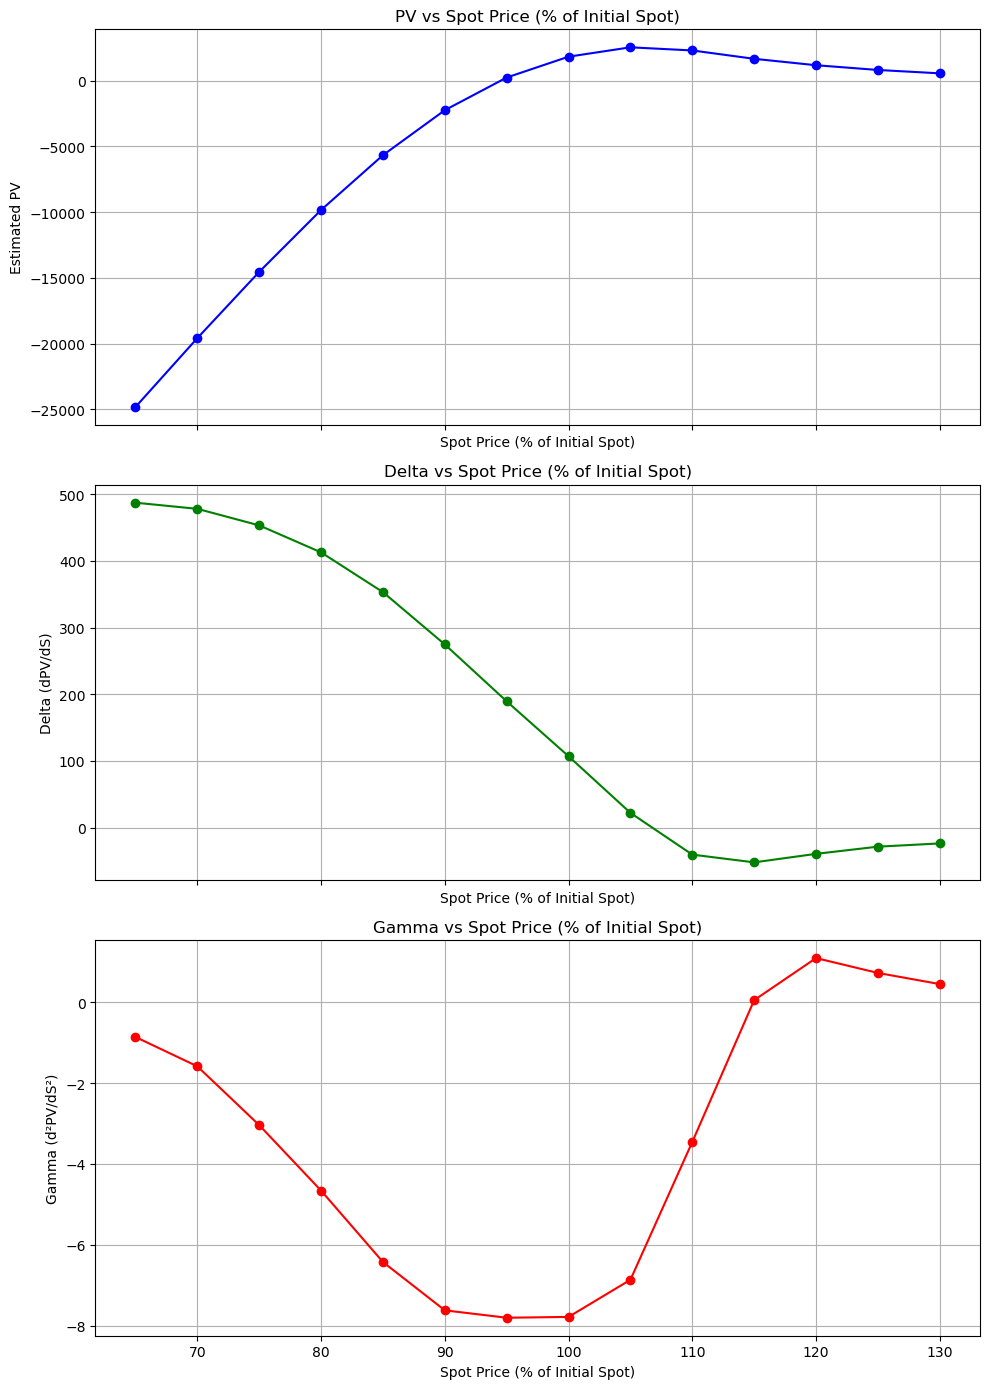

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_delta_gamma_vs_spot(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=None):
    """
    Simulate and plot the present value (PV), delta, and gamma of the ACDC contract as a function of the initial spot price.
    
    Also, store the spot prices, PV, delta, and gamma values in a CSV file.
    
    Parameters:
        S0_range (array-like): Array of initial spot prices.
        r (float): Risk-free rate.
        sigma (float): Volatility.
        T (float): Time to expiry in years.
        N_paths (int): Number of Monte Carlo simulation paths.
        N_periods (int): Number of settlement periods.
        days_per_year (int): Number of trading days per year.
        m (float): Number of shares accumulated per eligible day.
        strike_pct (float): Strike as a percentage of S0.
        barrier_pct (float): Barrier as a percentage of S0.
        G (float): Gearing factor.
        contract_type (str): Either 'accumulator' or 'decumulator'.
        seed (int or None): Seed for reproducibility.
    """
    # Define spot prices as a percentage of S0 from 65% to 130% in 5% increments
    spot_pct_range = np.arange(65, 135, 5)  # From 65% to 130% with 5% step
    S0_range = S0 * (spot_pct_range / 100.0)  # Convert percentage to actual spot prices

    PVs = []
    for S0 in S0_range:
        # Recalculate strike and barrier based on the current S0
        #K = S0 * (strike_pct / 100.0)
        #B = S0 * (barrier_pct / 100.0)
        # Call the simulation function (assumed to be defined elsewhere)
        price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
        PVs.append(price)
    PVs = np.array(PVs)
    
    # Compute numerical derivatives: delta as first derivative, gamma as second derivative.
    delta = np.gradient(PVs, S0_range)
    gamma = np.gradient(delta, S0_range)
    
    # Save spot percentage, PV, delta, and gamma in a CSV file.
    data = np.vstack((spot_pct_range, PVs, delta, gamma)).T
    np.savetxt("acdc_simulation_percentage_data.csv", data, delimiter=",", header="Spot_pct,PV,Delta,Gamma", comments="")
    print("Saved spot percentage, PV, delta, and gamma values to acdc_simulation_percentage_data.csv")
    
# Create a figure with 3 subplots: one for PV, one for delta, and one for gamma.
    fig, axs = plt.subplots(3, 1, figsize=(10, 14), sharex=True)
    
    axs[0].plot(spot_pct_range, PVs, marker='o', linestyle='-', color='b')
    axs[0].set_title('PV vs Spot Price (% of Initial Spot)')
    axs[0].set_xlabel('Spot Price (% of Initial Spot)')
    axs[0].set_ylabel('Estimated PV')
    axs[0].grid(True)
    
    axs[1].plot(spot_pct_range, delta, marker='o', linestyle='-', color='g')
    axs[1].set_title('Delta vs Spot Price (% of Initial Spot)')
    axs[1].set_xlabel('Spot Price (% of Initial Spot)')
    axs[1].set_ylabel('Delta (dPV/dS)')
    axs[1].grid(True)
    
    axs[2].plot(spot_pct_range, gamma, marker='o', linestyle='-', color='r')
    axs[2].set_title('Gamma vs Spot Price (% of Initial Spot)')
    axs[2].set_xlabel('Spot Price (% of Initial Spot)')
    axs[2].set_ylabel('Gamma (d²PV/dS²)')
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Example usage:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    strike_pct = 90
    barrier_pct = 110
    r = 0.0507          # risk-free rate (annualized).
    sigma = 0.2          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 252  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte Carlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = S0 * (strike_pct / 100.0)          # strike price.
    B = S0 * (barrier_pct / 100.0)         # knock-out barrier.
    G = 2                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 399          # seed for reproducibility.
    
    # Define a range of S0 values to explore
    #S0_range = np.linspace(138, 280, 140)
    
    # Plot PV, delta, and gamma versus spot percentage and store all data for each percentage in a file
    plot_delta_gamma_vs_spot(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=seed)

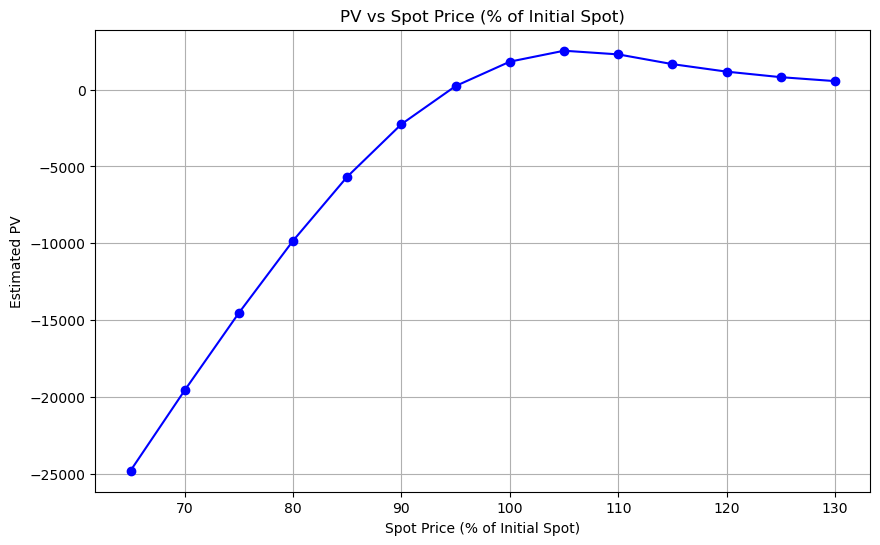

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_delta_gamma_vs_spot(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=None):
    """
    Simulate and plot the present value (PV), delta, and gamma of the ACDC contract as a function of the initial spot price.
    
    Also, store the spot prices, PV, delta, and gamma values in a CSV file.
    
    Parameters:
        S0_range (array-like): Array of initial spot prices.
        r (float): Risk-free rate.
        sigma (float): Volatility.
        T (float): Time to expiry in years.
        N_paths (int): Number of Monte Carlo simulation paths.
        N_periods (int): Number of settlement periods.
        days_per_year (int): Number of trading days per year.
        m (float): Number of shares accumulated per eligible day.
        strike_pct (float): Strike as a percentage of S0.
        barrier_pct (float): Barrier as a percentage of S0.
        G (float): Gearing factor.
        contract_type (str): Either 'accumulator' or 'decumulator'.
        seed (int or None): Seed for reproducibility.
    """
    # Define spot prices as a percentage of S0 from 65% to 130% in 5% increments
    spot_pct_range = np.arange(65, 135, 5)  # From 65% to 130% with 5% step
    S0_range = S0 * (spot_pct_range / 100.0)  # Convert percentage to actual spot prices

    PVs = []
    for S0 in S0_range:
        # Recalculate strike and barrier based on the current S0
        #K = S0 * (strike_pct / 100.0)
        #B = S0 * (barrier_pct / 100.0)
        # Call the simulation function (assumed to be defined elsewhere)
        price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
        PVs.append(price)
    PVs = np.array(PVs)
    
    # Compute numerical derivatives: delta as first derivative, gamma as second derivative.
    delta = np.gradient(PVs, S0_range)
    gamma = np.gradient(delta, S0_range)
    
# Plot PV vs Spot Price (% of Initial Spot)
    plt.figure(figsize=(10, 6))
    plt.plot(spot_pct_range, PVs, marker='o', linestyle='-', color='b')
    plt.title('PV vs Spot Price (% of Initial Spot)')
    plt.xlabel('Spot Price (% of Initial Spot)')
    plt.ylabel('Estimated PV')
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    strike_pct = 90
    barrier_pct = 110
    r = 0.0507          # risk-free rate (annualized).
    sigma = 0.2          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 252  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte Carlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = S0 * (strike_pct / 100.0)          # strike price.
    B = S0 * (barrier_pct / 100.0)         # knock-out barrier.
    G = 2                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 399          # seed for reproducibility.
    
    # Define a range of S0 values to explore
    #S0_range = np.linspace(138, 280, 140)
    
    # Plot PV, delta, and gamma versus spot percentage and store all data for each percentage in a file
    plot_delta_gamma_vs_spot(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=seed)